In [1]:
import os
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
sys.path.append('./Mask_RCNN')
from Mask_RCNN import utils
from Mask_RCNN import model as modellib
from Sixd_Copy1 import SixdConfig, SixdDataset
from sixd_test import SixdTestDataset
import visualize
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

class InferenceConfig(SixdConfig):
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1
    
#file_dir = os.path.dirname(os.path.abspath(__file__))
#project_dir = os.path.dirname(file_dir)

dataset_coco_dir = '../datasets/coco'
dataset_sixd_dir = '../datasets/sixd/doumanoglou/train'

COCO_MODEL_PATH = 'Mask_RCNN/mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

config = SixdConfig()

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

inference_config = InferenceConfig()
# Recreate the model in inference mode
with tf.device("/gpu:1"):
    model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='logs')

/home/mjakobsen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_train = SixdDataset()
dataset_train.load_sixd(3000, dataset_coco_dir, 'train', dataset_sixd_dir)
dataset_train.prepare()

dataset_val = SixdDataset()
dataset_val.load_sixd(250, dataset_coco_dir, 'val', dataset_sixd_dir)
dataset_val.prepare()

dataset_test = SixdTestDataset()
dataset_test.load_sixd_test("/home/rhaugaard/shared/3D-pose-est-aid/datasets/sixd/doumanoglou/test", "/home/mjakobsen/workspace/scene-annotator/output/scene-annotator")
dataset_test.prepare()

Using cached definition file: image_def_train2017_3000.yaml
Using cached definition file: image_def_val2017_250.yaml


In [4]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = model.find_last()[1]
model_path = 'logs/sixd20180406T1527/mask_rcnn_sixd_0004.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs/sixd20180406T1527/mask_rcnn_sixd_0004.h5


In [114]:
print(image_id)

25


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  640.00000  float64
gt_class_id              shape: (9,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (9, 4)                min:   32.00000  max:  506.00000  int32
gt_mask                  shape: (512, 512, 9)         min:    0.00000  max:    1.00000  bool


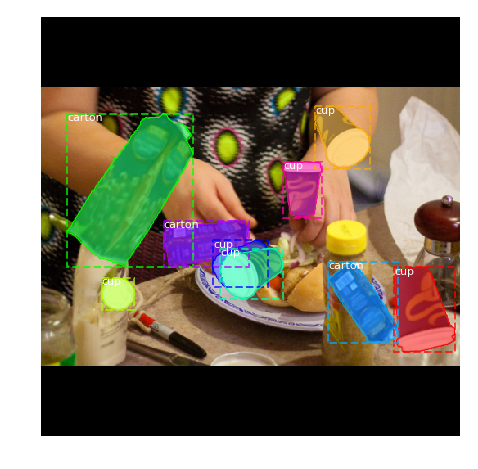

In [7]:
# Test on a random image

from model import log
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

In [6]:
#from PIL import Image
#import numpy as np
#original_image = Image.open('../datasets/sixd/doumanoglou/test/01/rgb/0004.png')
#original_image = np.array(original_image)
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

AssertionError: len(images) must be equal to BATCH_SIZE

In [9]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = np.random.choice(dataset_val.image_ids, 200)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7437197366491871


In [11]:
image_ids = dataset_test.image_ids
APmeans = []
print("TEST")
for i in range(1, 31):
    model.load_weights('logs/sixd20180406T1527/mask_rcnn_sixd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_test', APmeans)

print("VAL")
image_ids = np.random.choice(dataset_val.image_ids, 200)
APmeans_val = []
for i in range(1, 31):
    model.load_weights('logs/sixd20180406T1527/mask_rcnn_sixd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans_val.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_val', APmeans_val)

print("TRAIN")
image_ids = np.random.choice(dataset_train.image_ids, 200)
APmeans_train = []
for i in range(1, 31):
    model.load_weights('logs/sixd20180406T1527/mask_rcnn_sixd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_train, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans_train.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_train', APmeans_train)

TEST
Epoch  1  - mAP:  0.3564556613380294
Epoch  2  - mAP:  0.4223770491226504
Epoch  3  - mAP:  0.4660236798908114
Epoch  4  - mAP:  0.4921996621697875
Epoch  5  - mAP:  0.48189395185573036
Epoch  6  - mAP:  0.47809739123134654
Epoch  7  - mAP:  0.4802703181599855
Epoch  8  - mAP:  0.49858288089991465
Epoch  9  - mAP:  0.45770317125101423
Epoch  10  - mAP:  0.4645145068198259
Epoch  11  - mAP:  0.4551461273639639
Epoch  12  - mAP:  0.457426525899277
Epoch  13  - mAP:  0.47551320620677284
Epoch  14  - mAP:  0.4451457952896007
Epoch  15  - mAP:  0.4512437797654831
Epoch  16  - mAP:  0.4847072919108061
Epoch  17  - mAP:  0.47149257317412235
Epoch  18  - mAP:  0.46434229630375734
Epoch  19  - mAP:  0.4166221099547597
Epoch  20  - mAP:  0.48176700714765996
Epoch  21  - mAP:  0.5041850937697413
Epoch  22  - mAP:  0.44216135140527735
Epoch  23  - mAP:  0.42535643981806026
Epoch  24  - mAP:  0.4411197252418634
Epoch  25  - mAP:  0.45503269047993766
Epoch  26  - mAP:  0.4256445244232358
Epoch 

hej


TEST
Epoch  31  - mAP:  0.46534199514153596
Epoch  32  - mAP:  0.4158280373472736
Epoch  33  - mAP:  0.40437295950069335
Epoch  34  - mAP:  0.427326595074299
Epoch  35  - mAP:  0.4224446993342191
Epoch  36  - mAP:  0.3955776962119462
Epoch  37  - mAP:  0.4755177858589528
Epoch  38  - mAP:  0.467872550823034
Epoch  39  - mAP:  0.447700050961882
Epoch  40  - mAP:  0.4551000819378817
Epoch  41  - mAP:  0.4178819092511564
Epoch  42  - mAP:  0.4450797986314012
Epoch  43  - mAP:  0.3914526892845535
Epoch  44  - mAP:  0.4335987069480804
Epoch  45  - mAP:  0.4629469356757204
Epoch  46  - mAP:  0.377994364641616
Epoch  47  - mAP:  0.3798038504981096
Epoch  48  - mAP:  0.42889915318184696
Epoch  49  - mAP:  0.42821088060813234
Epoch  50  - mAP:  0.39335479947639496
Epoch  51  - mAP:  0.3633854166901912
Epoch  52  - mAP:  0.40758408572037047
Epoch  53  - mAP:  0.36013940013514956
Epoch  54  - mAP:  0.43445384050568087
Epoch  55  - mAP:  0.4169771506192681
Epoch  56  - mAP:  0.37812025029602886
Ep

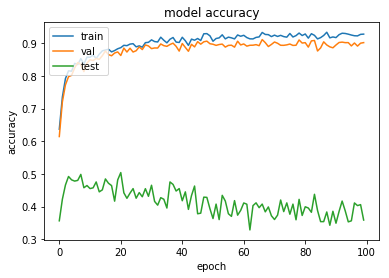

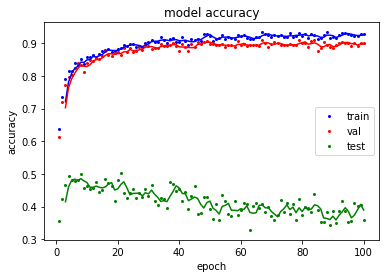

In [13]:
def movingaverage (values, window):
    return np.convolve(values, np.repeat(1.0, window)/window, 'valid')

epochs = range(1, 101)
APtrain = np.load('APs/AP_train_100.npy')
APval = np.load('APs/AP_val_100.npy')
APtest = np.load('APs/AP_test_100.npy')

APtestMA = movingaverage(APtest, 3)
APvalMA = movingaverage(APval, 3)
APtrainMA = movingaverage(APtrain, 3)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(epochs, APtrain, 'bo', markersize=2)
plt.plot(epochs, APval, 'ro', markersize=2)
plt.plot(epochs, APtest, 'go', markersize=2)
plt.plot(epochs[len(epochs)-len(APtrainMA):], APtrainMA, 'b-')
plt.plot(epochs[len(epochs)-len(APvalMA):], APvalMA, 'r-')
plt.plot(epochs[len(epochs)-len(APtestMA):], APtestMA, 'g-')
plt.legend(['train','val','test'], loc='right')
plt.savefig("graph.svg")
plt.show()

rois                     shape: (4, 64, 4)            min:    5.00000  max:  503.00000  int32
mrcnn_class_ids          shape: (4, 64, 1)            min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 64, 3, 4)         min:   -3.50000  max:    2.89039  float32
mrcnn_mask               shape: (4, 64, 28, 28, 3)    min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  438.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  float64
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -5.86626  max:    2.45878  float64
anchors                  shape: (65472, 4)            min: -181.01934  max:  629.01934  float64
refined_anchors          shape: (15, 4)           

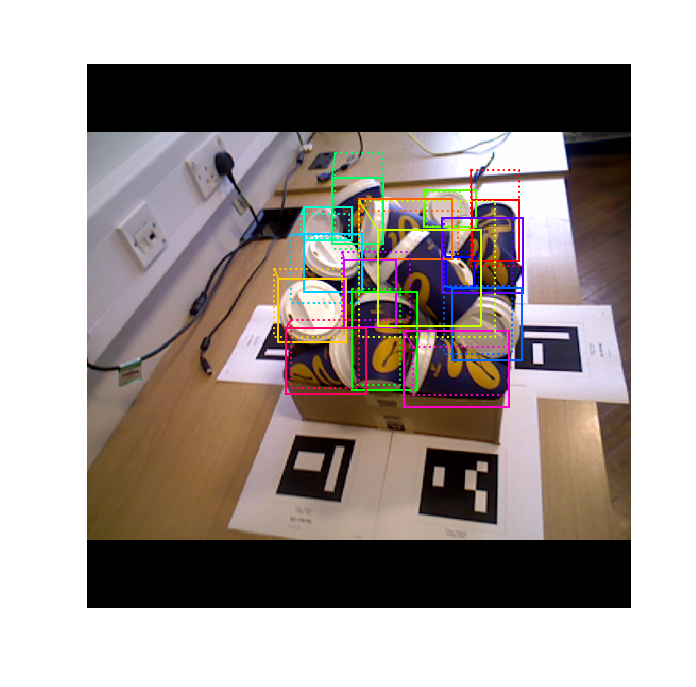

In [13]:
dataset = dataset_test
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
#print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

Positive ROIs:  21
Negative ROIs:  43
Positive Ratio: 0.33
Unique ROIs: 62 out of 64


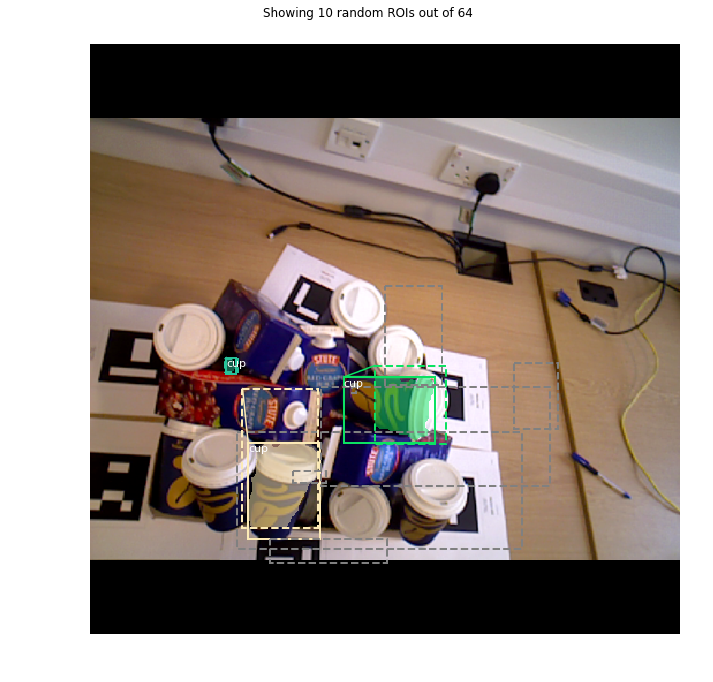

In [10]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))